# Load Data

- https://www.kaggle.com/datasets/tariq9mehmood9/eeg-visual-classification?select=imagenet_class_labels.txt

In [1]:
import torch
import torch.nn as nn

In [2]:
eeg_path = 'data/eeg_signals_raw_with_mean_std.pth'
captions_path = 'data/captions_data.pth'
block_path = 'data/block_splits_by_image_all.pth'


In [3]:
eeg_path = torch.load(eeg_path)
captions_torch = torch.load(captions_path)
block_path = torch.load(block_path)

In [4]:
len(captions_torch['captions'])

1996

In [5]:
eeg_path['dataset'][0]['eeg'].shape
# 128 channel, sampling rate 250?
# There is no specific information, so it is difficult to do feature extraction such as FFT, PSD

torch.Size([128, 500])

In [6]:
import matplotlib.pyplot as plt

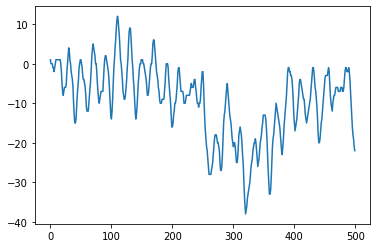

In [7]:
plt.plot(eeg_path['dataset'][0]['eeg'][3])

In [8]:
images = []
labels = []
subjects = []
for data in eeg_path['dataset']:
    images.append(data['image'])
    labels.append(data['label'])
    subjects.append(data['subject'])


<AxesSubplot:xlabel='label', ylabel='count'>

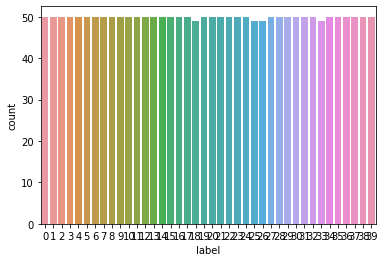

In [9]:
import pandas as pd
import seaborn as sns

users_df = pd.DataFrame({'image' : images, 'label' : labels, 'subject' : subjects})
user_df = users_df[users_df['subject'] == 4]

sns.countplot(data=user_df, x='label')
# count of ['image'] is same as imagenet_class_labels
# (Assumption) ['image'] is same as those are written imagenet_class_labels 
# (Assumption) ['label'] is group of similar ['image']s

In [10]:
images_in_label = user_df[user_df['label'] == 1]['image'].values

In [11]:
for i in range(40):
    images_caption = captions_torch['captions'][user_df[user_df['label'] == i]['image'].values[0]]
    print(f'{i+1}.', images_caption)


1. A brown horse running across a lush green field.
2. A group of parachutes flying in the sky over a plane.
3. an ironing board with a white table cloth on it
4. A clown fish peeking out of an anemonic sea anemone.
5. La Marzocco Linea Mini 2 Group Espresso Machine
6. A group of coffee mugs sitting on top of a table.
7. A man riding a bike down a trail in the woods.
8. A person holding a revolver in their hand. 
9. A panda bear laying on its back in the grass.
10. A red and white flower with a yellow center.
11. A person in a pink kayak paddling down a river.
12. A small butterfly sitting on top of a flower.
13. A small dog sleeping on a couch with a blue blanket.
14. A pair of white and pink running shoes on a table.
15. A jack-o-lantern is lit up in the dark. 
16. A man wearing glasses talking on a cell phone.
17. A golf ball sitting on top of a green next to a hole.
18. A desktop computer sitting on top of a desk.
19. A man sweeping the ice with a broom and a yellow ball.
20. A piz

# Resize images
- Resize all images to 64 * 64

In [17]:
import glob
from PIL import Image


files = glob.glob('data/**')
for file in files:
    if 'jpg' in file:
        image = Image.open(file)
        image_resized = image.resize((64, 64))

        file_name = file.split('/')[1]
        image_resized.save(f'data/resized/{file_name}')


# Key Informations
- label : total 40(0~39)
- subjects : total 6
- images : total 1996 and each 50 similar images make the same group(label)
- eeg : (maybe) 128 channel and 250 or 500Hz

# First step : Can we distinguish each label through EEG?
- Approach 1 : with machine learning
- Approach 2 : with deep learning

# Approach2 - EEGNet

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [54]:
eeg_signals = []
labels = []

num_subject = 3

for entry in eeg_path['dataset']:
    if entry['subject'] == num_subject:
        eeg_signals.append(entry['eeg'][:, 64:320])
        labels.append(entry['label'])

X = torch.stack(eeg_signals)
y = torch.tensor(labels)

In [48]:
class EEGNet(nn.Module):
    def __init__(self, num_classes=40):
        super(EEGNet, self).__init__()

        # temporal convolution
        self.conv1 = nn.Conv2d(1, 8, (1,64), padding=(0, 32), bias=False)
        self.batch_norm1 = nn.BatchNorm2d(8)

        # depthwise convolution
        self.depthwise_conv = nn.Conv2d(8, 16, (128, 1), groups=8, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(16)
        self.elu = nn.ELU()
        self.avg_pool1 = nn.AvgPool2d((1,4))
        self.drpout1 = nn.Dropout(0.25)

        # separable convolution
        self.separable_conv = nn.Conv2d(16, 16, (1,16), padding=(0, 8), bias=False)
        self.batch_norm3 = nn.BatchNorm2d(16)
        self.avg_pool2 = nn.AvgPool2d((1, 8))
        self.dropout2 = nn.Dropout(0.25)

        # FC layer
        self.fc = nn.Linear(16 * 256 // 32, num_classes) # adjust dimensions

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        
        x = self.depthwise_conv(x)
        x = self.batch_norm2(x)
        x = self.elu(x)
        x = self.avg_pool1(x)
        x = self.drpout1(x)
        
        x = self.separable_conv(x)
        x = self.batch_norm3(x)
        x = self.avg_pool2(x)
        x = self.dropout2(x)

        x = x.view(x.size(0), -1) # flatten
        x = self.fc(x)

        return x
        

In [55]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train = X_train.unsqueeze(1)
X_valid = X_valid.unsqueeze(1)

X_train = X_train.float()
X_valid = X_valid.float()


print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_valid:", X_valid.shape)
print("Shape of y_valid:", y_valid.shape)

print("Data type of X_train:", X_train.dtype) 
print("Data type of X_valid:", X_valid.dtype) 

Shape of X_train: torch.Size([1596, 1, 128, 256])
Shape of y_train: torch.Size([1596])
Shape of X_valid: torch.Size([400, 1, 128, 256])
Shape of y_valid: torch.Size([400])
Data type of X_train: torch.float32
Data type of X_valid: torch.float32


In [56]:
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [57]:
model = EEGNet(num_classes=40)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [58]:
for epoch in range(10):
    model.train()
    for batch in dataloader:
        inputs, labels = batch
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch + 1}, Loss : {loss.item()}')

Epoch 1, Loss : 2.7425734996795654
Epoch 2, Loss : 1.9903556108474731
Epoch 3, Loss : 1.2148157358169556
Epoch 4, Loss : 1.0325723886489868
Epoch 5, Loss : 0.5596059560775757
Epoch 6, Loss : 0.4458475708961487
Epoch 7, Loss : 0.29045623540878296
Epoch 8, Loss : 0.2957540452480316
Epoch 9, Loss : 0.2843899130821228
Epoch 10, Loss : 0.07915980368852615


In [59]:
model.eval()

total_loss = 0.0
correct_predicctions = 0

with torch.no_grad():
    for i in range(len(X_valid)):
        inputs = X_valid[i].unsqueeze(0)
        labels = y_valid[i].unsqueeze(0)

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        total_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        if predicted.item() == labels.item():
            correct_predicctions += 1

average_loss = total_loss / len(X_valid)
accuracy = correct_predicctions / len(X_valid)

print(f"Validation Loss: {average_loss:.4f}")
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

Validation Loss: 0.1085
Validation Accuracy: 99.25%


# Second Step
- Reconstruction Image using EEG
- It is difficult to find real used images, so search images using caption imformation

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset

In [11]:
# class EEG_Generator(nn.Module):
#     def __init__(self, z_dim=128):
#         super(EEG_Generator, self).__init__()

#         self.fc1 = nn.Linear(z_dim, 256)
#         self.fc2 = nn.Linear(256, 512)
#         self.fc3 = nn.Linear(512, 1024)
#         self.fc4 = nn.Linear(1024, 3 * 64 * 64) # output : 3channels, 64 * 64 image

#         self.final_conv = nn.Sequential(
#             nn.BatchNorm2d(3),
#             nn.Tanh()
#         ) # reshape to image dimension

#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = F.relu(self.fc3(x))
#         x = self.fc4(x)

#         x = x.view(x.size(0), 3, 64, 64)

#         return self.final_conv(x)

class EEG_Generator(nn.Module):
    def __init__(self, eeg_channels=128, eeg_timesteps=256):
        super(EEG_Generator, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=eeg_channels, out_channels=256, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1)
        self.fc1 = nn.Linear(512 * (eeg_timesteps // 4), 1024)
        self.fc2 = nn.Linear(1024, 3 * 64 * 64)  # Output: 3 channels, 64 * 64 image
        self.final_conv = nn.Sequential(
            nn.BatchNorm2d(3),
            nn.Tanh()
        )

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(x.size(0), 3, 64, 64)  # Reshape to image dimension
        return self.final_conv(x)


In [12]:
class EEG_Discriminator(nn.Module):
    def __init__(self):
        super(EEG_Discriminator, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.fc1 = nn.Linear(128 * 16 * 16, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = x.view(x.size(0), -1) # Flatten
        x = self.fc1(x)
        x = self.sigmoid(x)

        return x

In [14]:
import numpy as np
from PIL import Image

eeg_signals = []
images = []

num_subject = 3

for entry in eeg_path['dataset']:
    if entry['subject'] == num_subject:
        eeg_signals.append(entry['eeg'][:, 64:320])
        label = entry['label']
        img =  Image.open(f'data/resized/{label+1}.jpg')
        img_np = np.array(img) 
        img_tensor = torch.tensor(img_np, dtype=torch.float32).permute(2, 0, 1)
        images.append(img_tensor)

X = torch.stack(eeg_signals)
y = torch.stack(images)

print(X.shape)
print(y.shape)

torch.Size([1996, 128, 256])
torch.Size([1996, 3, 64, 64])


In [15]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.float()
X_valid = X_valid.float()


print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_valid:", X_valid.shape)
print("Shape of y_valid:", y_valid.shape)

print("Data type of X_train:", X_train.dtype) 
print("Data type of X_valid:", X_valid.dtype) 

Shape of X_train: torch.Size([1596, 128, 256])
Shape of y_train: torch.Size([1596, 3, 64, 64])
Shape of X_valid: torch.Size([400, 128, 256])
Shape of y_valid: torch.Size([400, 3, 64, 64])
Data type of X_train: torch.float32
Data type of X_valid: torch.float32


In [16]:
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [17]:
generator = EEG_Generator()
discriminator = EEG_Discriminator()

In [30]:
import torch.optim as optim

learning_rate = 0.000001

generator_optimizer = optim.Adam(generator.parameters(), lr=learning_rate)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate)

In [31]:
criterion = nn.BCELoss()
batch_size = 32

# real_labels = torch.ones(batch_size, 1)
# fake_labels = torch.zeros(batch_size, 1)

real_labels_smooth = 0.9  # Real labels with smoothing
fake_labels_smooth = 0.1  # Fake labels with smoothing

num_epochs = 50

for epoch in range(num_epochs):
    for i, (eeg_data, real_images) in enumerate(dataloader):
        try:
            # 1. Train Discriminator
            # Generate fake images
            fake_images = generator(eeg_data)

            real_labels = torch.full((batch_size, 1), real_labels_smooth)
            fake_labels = torch.full((batch_size, 1), fake_labels_smooth)
            
            # Calculate the discriminator loss
            real_loss = criterion(discriminator(real_images), real_labels)
            fake_loss = criterion(discriminator(fake_images), fake_labels)
            d_loss = real_loss + fake_loss
    
            discriminator_optimizer.zero_grad()
            d_loss.backward(retain_graph=True)
            discriminator_optimizer.step()
            
            # 2. Train Generator
            # Generator tries to fool the discriminator into thinking fake images are real
            g_loss = criterion(discriminator(fake_images), real_labels)
    
            generator_optimizer.zero_grad()
            g_loss.backward()
            generator_optimizer.step()
        except ValueError:
            continue
        
    print(f"Epoch [{epoch+1}/{num_epochs}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")


Epoch [1/50], D Loss: 9.074335098266602, G Loss: 5.2477126121521
Epoch [2/50], D Loss: 9.370064735412598, G Loss: 5.1886773109436035
Epoch [3/50], D Loss: 9.362719535827637, G Loss: 5.120303630828857
Epoch [4/50], D Loss: 10.262611389160156, G Loss: 5.053802967071533
Epoch [5/50], D Loss: 9.649782180786133, G Loss: 4.979791164398193
Epoch [6/50], D Loss: 9.945307731628418, G Loss: 4.914255142211914
Epoch [7/50], D Loss: 8.72907543182373, G Loss: 4.8485212326049805
Epoch [8/50], D Loss: 9.32663631439209, G Loss: 4.7813920974731445
Epoch [9/50], D Loss: 9.923928260803223, G Loss: 4.713103294372559
Epoch [10/50], D Loss: 9.009888648986816, G Loss: 4.6458892822265625
Epoch [11/50], D Loss: 9.607682228088379, G Loss: 4.580560207366943
Epoch [12/50], D Loss: 9.903314590454102, G Loss: 4.517148971557617
Epoch [13/50], D Loss: 10.501107215881348, G Loss: 4.452593803405762
Epoch [14/50], D Loss: 9.285672187805176, G Loss: 4.387509346008301
Epoch [15/50], D Loss: 9.580489158630371, G Loss: 4.318

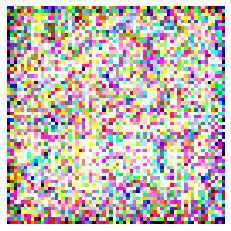

In [32]:
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

generator.eval()

valid_eeg_data = X_valid[0].unsqueeze(0)  # Replace this with actual EEG data

with torch.no_grad():  # Disable gradient computation during inference
    generated_image = generator(valid_eeg_data)

# The generated image will have shape [batch_size, 3, 64, 64] (3 channels, 64x64 image)
generated_image = generated_image.squeeze(0)  # Remove the batch dimension (to get [3, 64, 64])

# Convert the image from tensor to PIL image for visualization
to_pil = ToPILImage()
generated_image_pil = to_pil(generated_image.cpu())

# Display the generated image
plt.imshow(generated_image_pil)
plt.axis('off')
plt.show()
